In [59]:
import sys
sys.path.append('./survival_utils')

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression

from causallib.estimation import IPW, Standardization, DoublyRobustVanilla
from causallib.evaluation import PropensityEvaluator, OutcomeEvaluator
from ow import OW

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
DAYS_IN_YEAR = 365.25
from Survival_Analysis import Survival_Analysis

# Load NHFES data

Available for download at https://cdn1.sph.harvard.edu/wp-content/uploads/sites/1268/1268/20/nhefs.csv

In [4]:
nhefs_all = pd.read_csv('../data/nhefs.csv').reset_index().rename(columns={'index':'pid'})
nhefs_all.head(2)

,pid,seqn,qsmk,death,yrdth,modth,dadth,sbp,dbp,sex,...,birthcontrol,pregnancies,cholesterol,hightax82,price71,price82,tax71,tax82,price71_82,tax71_82
0,0,233,0,0,NaN,NaN,NaN,175.0,96.0,0,...,2,NaN,197.0,0.0,2.183594,1.739990,1.102295,0.461975,0.443787,0.640381
1,1,235,0,0,NaN,NaN,NaN,123.0,80.0,0,...,2,NaN,301.0,0.0,2.346680,1.797363,1.364990,0.571899,0.549316,0.792969


## Add interactions, dummies, propensity score and weights to the full data

In [5]:
def calc_propensity(y, X):
    """
    Calculate propensity score from logistic regression
    
    Parameters
    ----------
    y : Pandas Series
    X : Pandas DataFrame
    
    Returns
    -------
    Numpy array of propensity scores
    
    """
    model = sm.Logit(y, X)
    res = model.fit()
    pscores = np.zeros(X.shape[0])
    pscores = res.predict(X)
    return pscores

def logit_ip_weights(y, X):
    """
    Create IP weights from logistic regression
    
    Parameters
    ----------
    y : Pandas Series
    X : Pandas DataFrame
    
    Returns
    -------
    Numpy array of IP weights
    
    """
    model = sm.Logit(y, X)
    res = model.fit()
    weights = np.zeros(X.shape[0])
    weights[y == 1] = res.predict(X.loc[y == 1])
    weights[y == 0] = 1 - res.predict(X.loc[y == 0])
    return weights
    

for col in ['age', 'wt71', 'smokeintensity', 'smokeyrs']:
    nhefs_all['{}_sqr'.format(col)] = nhefs_all[col] * nhefs_all[col]
    
nhefs_all['one'] = 1
edu_dummies = pd.get_dummies(nhefs_all.education, prefix='edu')
exercise_dummies = pd.get_dummies(nhefs_all.exercise, prefix='exercise')
active_dummies = pd.get_dummies(nhefs_all.active, prefix='active')

nhefs_all = pd.concat(
    [nhefs_all, edu_dummies, exercise_dummies, active_dummies],
    axis=1
)

X = nhefs_all[['one', 'sex', 'race', 'edu_2', 'edu_3', 'edu_4', 'edu_5', 'exercise_1', 'exercise_2', 'active_1', 'active_2',
               'age', 'age_sqr', 'wt71', 'wt71_sqr','smokeintensity', 'smokeintensity_sqr', 'smokeyrs', 'smokeyrs_sqr']]

nhefs_all['pscore'] = calc_propensity(nhefs_all.qsmk, X)
ip_denom = logit_ip_weights(nhefs_all.qsmk, X)

pr_qsmk = nhefs_all.qsmk.mean()

ip_numer = np.zeros(ip_denom.shape[0])
ip_numer[nhefs_all.qsmk == 0] = 1 - pr_qsmk
ip_numer[nhefs_all.qsmk == 1] = pr_qsmk

ip_weights = ip_numer / ip_denom
nhefs_all['IPW'] = ip_weights

nhefs_all['OW'] = 0.0
nhefs_all.loc[nhefs_all.qsmk == 1, 'OW'] = 1 - nhefs_all.loc[nhefs_all.qsmk == 1, 'pscore']
nhefs_all.loc[nhefs_all.qsmk == 0, 'OW'] = nhefs_all.loc[nhefs_all.qsmk == 0, 'pscore']

Optimization terminated successfully.
         Current function value: 0.542264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.542264
         Iterations 6


# Defs

In [6]:
# Prepare data
months_bins=1
pscore_col = 'pscore'
weights_col = ['IPW', 'OW']
id_col = 'seqn'
index_time_col = 'index_date'
outcome_time_col = 'date_death'
outcome_event_col = 'death'
TX_col = 'qsmk'
TX_labels_dict = {0:'Did not quit smoking', 1:'Quit smoking'}
TX_colors = {0:'royalblue', 1:'darkorange'}

followup_end_time = -int(7*DAYS_IN_YEAR) + 1
followup_max_time_from_index = int(10*DAYS_IN_YEAR) + 1
followup_max_time_from_index_binned = int(10*(12/months_bins)) + 1

ps_cols = ['one', 'sex', 'race', 'edu_2', 'edu_3', 'edu_4', 'edu_5', 'exercise_1', 'exercise_2', 'active_1', 'active_2',
            'age', 'age_sqr', 'wt71', 'wt71_sqr','smokeintensity', 'smokeintensity_sqr', 'smokeyrs', 'smokeyrs_sqr']

nhefs_all[index_time_col] = -(17*DAYS_IN_YEAR)
nhefs_all[outcome_time_col] = ((nhefs_all['yrdth']-100)*DAYS_IN_YEAR + nhefs_all['modth']*(DAYS_IN_YEAR/12))
nhefs_all[outcome_time_col] = nhefs_all[outcome_time_col].fillna(followup_max_time_from_index)
data = nhefs_all.dropna(subset=['qsmk'])[ps_cols + weights_col + [index_time_col, outcome_time_col, outcome_event_col, 
                                                    pscore_col, TX_col, id_col]].copy()
data['censoring'] = followup_end_time
data.head(2)

,one,sex,race,edu_2,edu_3,edu_4,edu_5,exercise_1,exercise_2,active_1,...,smokeyrs_sqr,IPW,OW,index_date,date_death,death,pscore,qsmk,seqn,censoring
0,1,0,1,0,0,0,0,0,1,0,...,841,0.827453,0.108998,-6209.25,3653.0,0,0.108998,0,233,-2555
1,1,0,0,1,0,0,0,0,0,0,...,576,0.866232,0.148886,-6209.25,3653.0,0,0.148886,0,235,-2555


In [7]:
data_df = data.drop([pscore_col, outcome_event_col, outcome_time_col] + weights_col, axis=1)
ps_df = data[[id_col, pscore_col] + weights_col + ps_cols]
outcome_df = data[[id_col, outcome_event_col, outcome_time_col, 'censoring']]

# Survival analysis - outcome: death, treatment: qsmk (quite smoking)

## Initialize class

In [8]:
survival_analysis = Survival_Analysis(data_df, outcome_df, outcome_time_col, 'censoring', 'Death', 
                                      id_col, index_time_col, TX_col, TX_labels_dict, TX_colors, followup_end_time, 
                                      followup_max_time_from_index, months_bins, ps_df, 'pscore', ps_cols, 'IPW', n_bootstraps=5)

## Fit and plot LR model

100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


Difference in survival probability at time 120: 5.5% (4.5, 8.2)
 Incident rate: Vagianl: 216, CS:102
Hazard ratio at time 120: 0.5 (0.4, 1.1)
Odds ratio at max followup: 0.2 (0.0, 0.5)


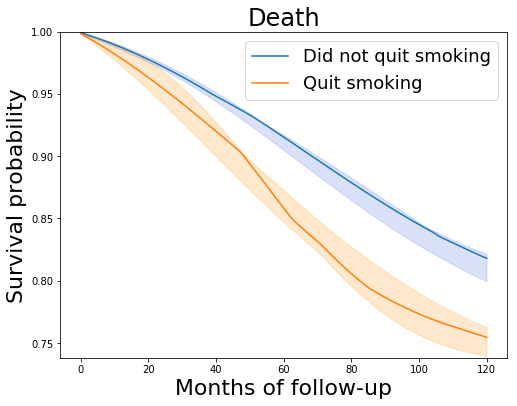

In [9]:
survival_analysis.estimate_survival(method='LR')
survival_analysis.plot_survival()
survival_analysis.survival_difference(followup_max_time_from_index_binned - 1)
survival_analysis.hazard_ratio(followup_max_time_from_index_binned - 1)
survival_analysis.odds_ratio_at_max_follwup()

## Fit and plot IPW LR model

100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Difference in survival probability at time 120: -0.7% (-2.6, 0.9)
 Incident rate: Vagianl: 216, CS:102
Hazard ratio at time 120: 0.3 (0.3, 0.5)
Odds ratio at max followup: 0.3 (0.0, 0.4)


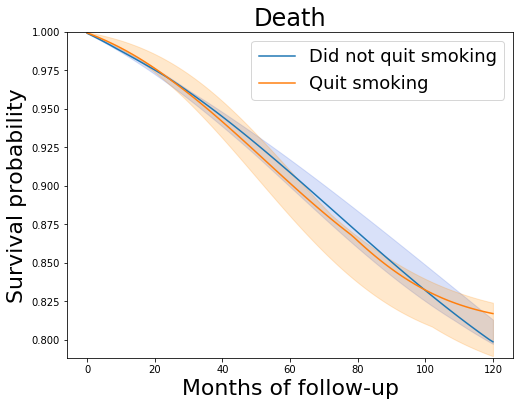

In [10]:
survival_analysis.estimate_survival(method='IPW')
survival_analysis.plot_survival()
survival_analysis.survival_difference(followup_max_time_from_index_binned - 1)
survival_analysis.hazard_ratio(followup_max_time_from_index_binned - 1)
survival_analysis.odds_ratio_at_max_follwup()

## Fit and plot OW LR model

100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


Difference in survival probability at time 120: -3.3% (-6.4, 2.8)
 Incident rate: Vagianl: 216, CS:102
Hazard ratio at time 120: 0.4 (0.3, 0.6)
Odds ratio at max followup: 0.2 (0.0, 0.5)


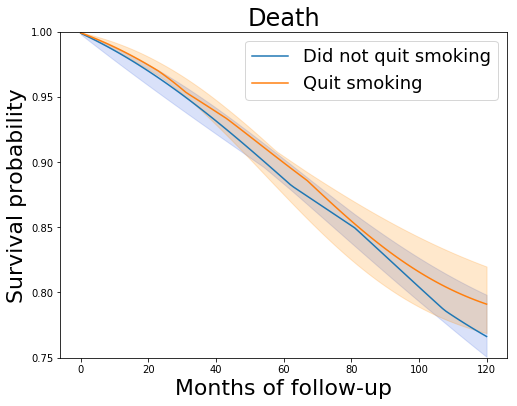

In [ ]:
survival_analysis_OW = Survival_Analysis(data_df, outcome_df, outcome_time_col, 'censoring', 'Death', 
                                         id_col, index_time_col, TX_col, TX_labels_dict, TX_colors, followup_end_time, 
                                         followup_max_time_from_index, months_bins, ps_df, 'pscore', ps_cols, 'OW', n_bootstraps=5)

survival_analysis_OW.estimate_survival(method='OW')
survival_analysis_OW.plot_survival()
survival_analysis_OW.survival_difference(followup_max_time_from_index_binned - 1)
survival_analysis_OW.hazard_ratio(followup_max_time_from_index_binned - 1)
survival_analysis_OW.odds_ratio_at_max_follwup()

## Fit and plot standardized model

In [ ]:
model = LogisticRegression(penalty='none', solver='lbfgs', max_iter=200)
# model = GradientBoostingClassifier(n_estimators=1000)

NUMERIC_FEATURES = ['age', 'age_sqr', 'wt71', 'wt71_sqr','smokeintensity', 'smokeintensity_sqr', 'smokeyrs', 'smokeyrs_sqr']
numeric_transformer = Pipeline(steps=[('std', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, NUMERIC_FEATURES)], remainder='passthrough')

survival_analysis.estimate_survival('STANDARDIZE', model, preprocessor, NUMERIC_FEATURES)
survival_analysis.plot_survival()
survival_analysis.survival_difference(followup_max_time_from_index_binned - 1)
survival_analysis.hazard_ratio(followup_max_time_from_index_binned - 1)
survival_analysis.odds_ratio_at_max_follwup()

  0%|          | 0/5 [00:00<?, ?it/s]

# ATE - outcome: cholesterol, treatment: qsmk (quite smoking)

Assume that the measure of cholesterol we have is at the end of the followup time, show how we calculate ATE using IPW, OW and Standadization

In [25]:
OUTCOME_COL = 'cholesterol'

cholesterol_data = nhefs_all.dropna(subset=[TX_col, OUTCOME_COL]).copy()

In [30]:
def _get_bootstrap_data(full_data, ps_cols, TX_col, outcome_col):
    tmp_data = full_data.dropna(subset=[TX_col, outcome_col]).copy()
    tmp_data = tmp_data.sample(n=len(tmp_data),replace=True).reset_index(drop=True)
    x, a, y = tmp_data[ps_cols], tmp_data[TX_col], tmp_data[outcome_col]
    return x, a, y

## ATE using IPW

ATE: 3.003426800618257 (0.5684749818085778, 6.722808728115427)


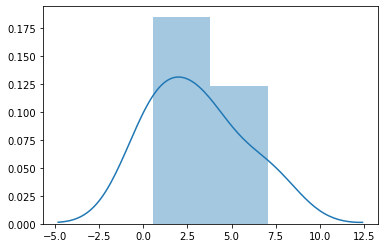

In [41]:
learner = XGBClassifier()
n_bootstraps = 5
diffs = []
ipw = IPW(learner)

for i in range(n_bootstraps):
    x, a, y = _get_bootstrap_data(cholesterol_data, ps_cols, TX_col, OUTCOME_COL)
    
    ipw.fit(x, a)
    outcomes = ipw.estimate_population_outcome(x, a, y)
    effect = ipw.estimate_effect(outcomes[1], outcomes[0])
    diffs.append(effect)

sns.distplot(diffs)

res = np.array(diffs).squeeze()
print('ATE: {} ({}, {})'.format(np.percentile(res, 50), np.percentile(res, 2.5), np.percentile(res, 97.5)))

## ATE using OW

ATE: 0.008089213012027585 (-1.5756925413886562, 3.375878927152456)


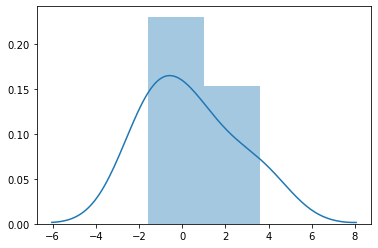

In [40]:
learner = XGBClassifier()
n_bootstraps = 5
diffs = []
ow = OW(learner)

for i in range(n_bootstraps):
    x,a,y = _get_bootstrap_data(cholesterol_data, ps_cols, TX_col, OUTCOME_COL)
    ow.fit(x, a)
    outcomes = ow.estimate_population_outcome(x, a, y)
    effect = ow.estimate_effect(outcomes[1], outcomes[0])
    diffs.append(effect)

sns.distplot(diffs)

res = np.array(diffs).squeeze()
print('ATE: {} ({}, {})'.format(np.percentile(res, 50), np.percentile(res, 2.5), np.percentile(res, 97.5)))

## ATE using Standardization

ATE: -0.7484149305072378 (-2.581861596156634, 1.5994074507164466)


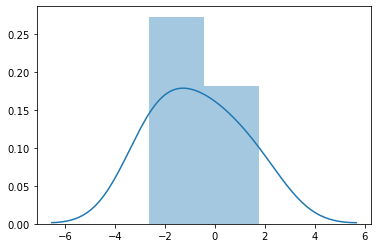

In [58]:
std_learner = LinearRegression()
n_bootstraps = 5
diffs = []

for i in range(n_bootstraps):
    x,a,y = _get_bootstrap_data(cholesterol_data, ps_cols, TX_col, OUTCOME_COL)

    std = Standardization(std_learner)
    std.fit(x, a, y)
    mean_pop_outcomes = std.estimate_population_outcome(x, a, agg_func='mean')
    mean_pop_outcomes.rename('mean', inplace=True)
    effect = std.estimate_effect(mean_pop_outcomes[1], mean_pop_outcomes[0])
    diffs.append(effect)

sns.distplot(diffs)

res = np.array(diffs).squeeze()
print('ATE: {} ({}, {})'.format(np.percentile(res, 50), np.percentile(res, 2.5), np.percentile(res, 97.5)))